# Capstone Project

## Image classifier for the SVHN dataset

### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish.

In [1]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

No broken requirements found.


In [3]:
import os
import numpy as np
import pandas as pd
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

![SVHN overview image](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/image/svhn/svhn_examples.jpg?raw=1)

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. In this capstone project, you will develop feedforward/MLP and convolutional neural newtwork classifier models for the Street View House Numbers (SVHN) dataset.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image of digits into one of ten classes.

In [2]:
os.makedirs('./data', exist_ok=True)

In [4]:
# Run this cell to load the dataset

train = sp.io.loadmat('./data/train_32x32.mat')
test = sp.io.loadmat('./data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [13]:
def load_svhn_data(train_data, test_data):
    """
    This function takes in the train_data and test_data as loaded in the
    cell above. Then, it extracts the images and labels separately, and 
    scales the images so that their values lie in the range [0, 1].
    This function returns a tuple (train_images, train_labels), 
    (test_images, test_labels) of the train and test dataset.
    """
    
    train_images = np.moveaxis(train_data['X'], -1, 0)
    train_images = train_images / 255.0
    test_images = np.moveaxis(test_data['X'], -1, 0)
    test_images = test_images / 255.0
    # Change the label of 10 to 0
    train_labels = np.squeeze(train_data['y'])
    train_labels = np.where(train_labels==10, 0, train_labels)
    test_labels = np.squeeze(test_data['y'])
    test_labels = np.where(test_labels==10, 0, test_labels)
    
    return (train_images, train_labels), (test_images, test_labels)
    
(train_images, train_labels), (test_images, test_labels) = \
    load_svhn_data(train, test)

print("Train_images shape: ", train_images.shape)
print("Train_labels shape: ", train_labels.shape)
print("Test_images shape: ", test_images.shape)
print("Test_labels shape: ", test_labels.shape)

Train_images shape:  (73257, 32, 32, 3)
Train_labels shape:  (73257,)
Test_images shape:  (26032, 32, 32, 3)
Test_labels shape:  (26032,)


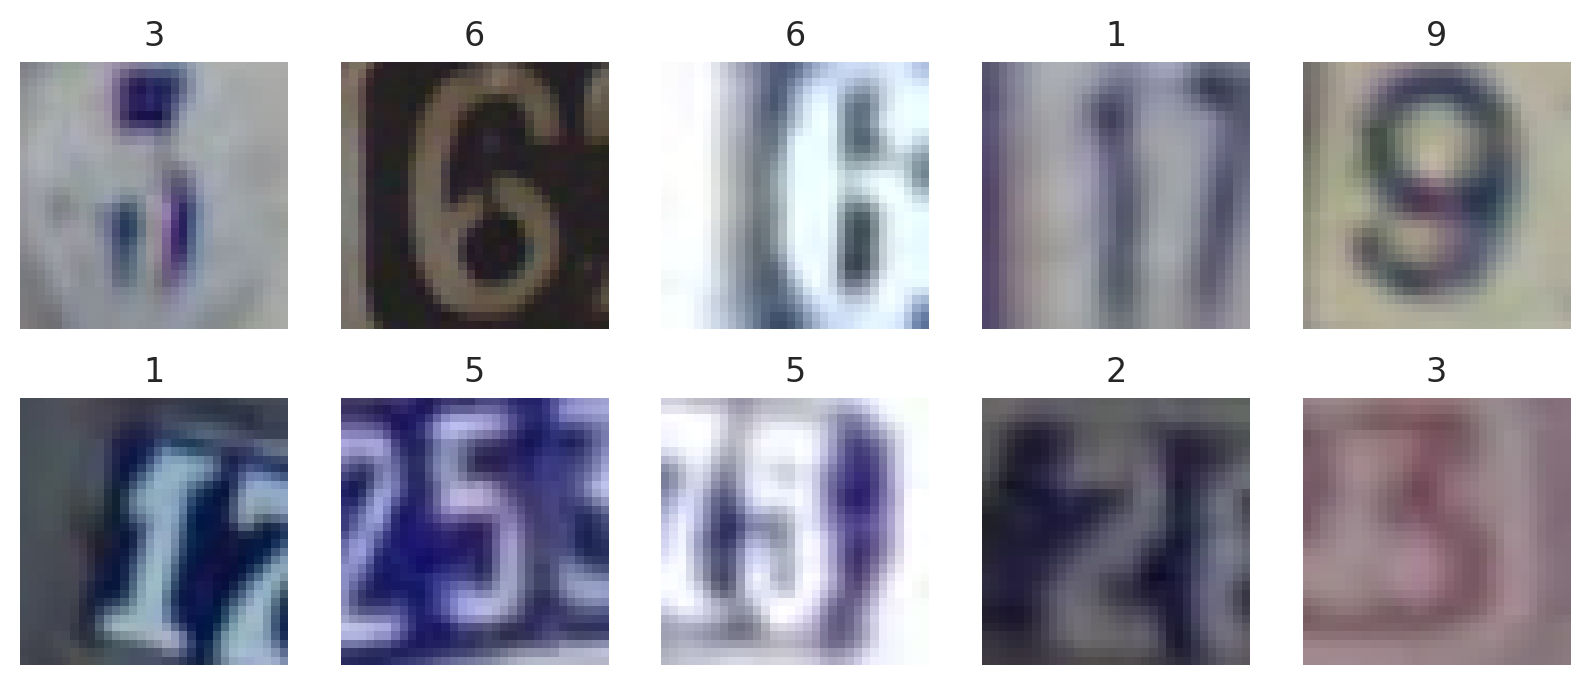

In [14]:
def plot_images(images, labels, cmap=None):
    """
    This function takes 10 random images and corresponding labels and display
    them in a figure.
    """
    
    fig = plt.figure(figsize=(10, 4))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_axis_off()
        ax.imshow(np.squeeze(images[i]), cmap=cmap)
        ax.set_title(labels[i])
    plt.show()

# Choose random 10 samples of train dataset
rand_idx = np.random.choice(train_labels.shape[0], 10)
images, labels = train_images[rand_idx], train_labels[rand_idx]

# Plot the images and labels
plot_images(images, labels)

In [15]:
def rgb2gray(image):
    """
    This function converts the image to grayscale by taking the 
    average across all colour channels for each pixel, and retains the
    channel dimension, which have size 1.
    """
    image = np.mean(image, axis=-1)
    
    return image[..., np.newaxis]

# Convert the RGB images of train and test to grayscale
train_images_gray = rgb2gray(train_images)
test_images_gray = rgb2gray(test_images)

print("Grayscale train_images shape: ", train_images_gray.shape)
print("Grayscale test_images shape: ", test_images_gray.shape)

Grayscale train_images shape:  (73257, 32, 32, 1)
Grayscale test_images shape:  (26032, 32, 32, 1)


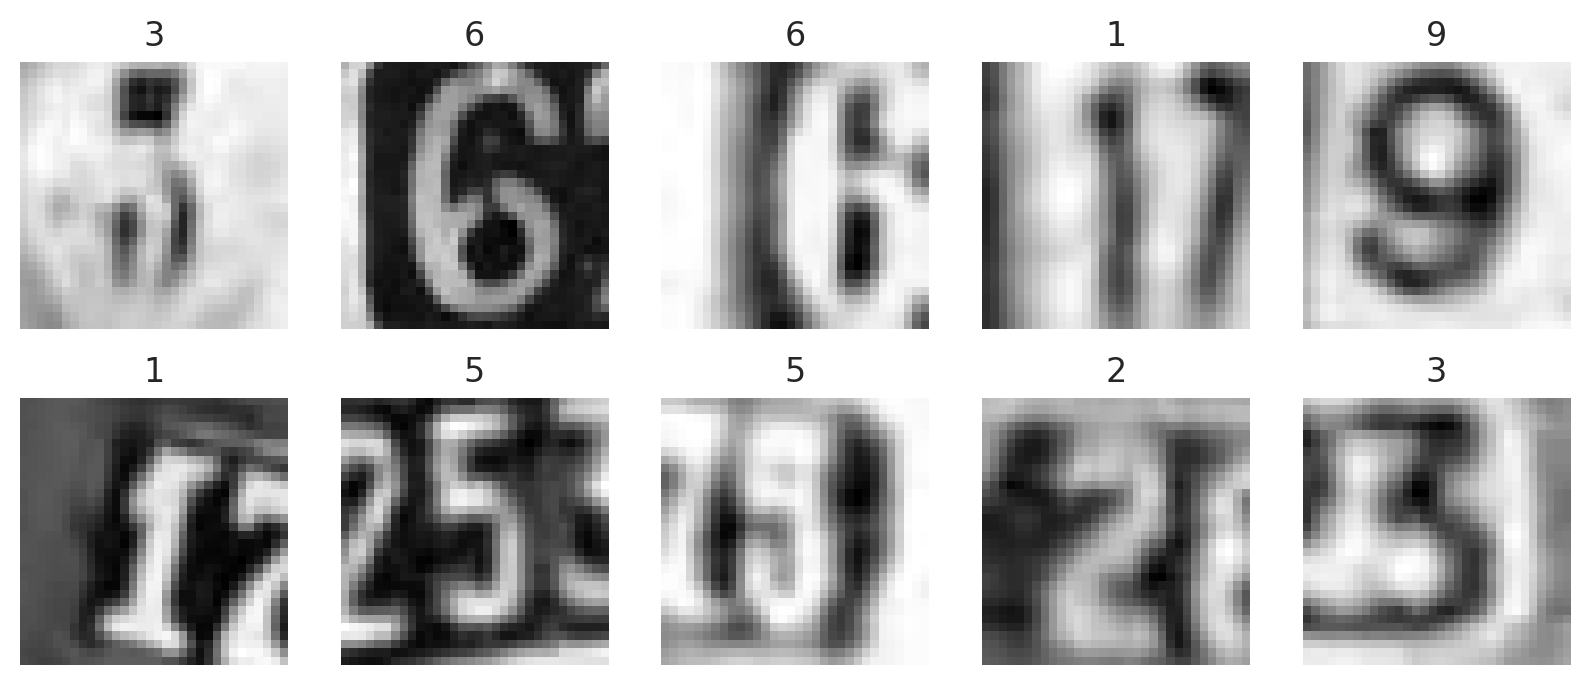

In [16]:
# Display the random samples of the grayscale images 
# and corresponding labels
images, labels = train_images_gray[rand_idx], train_labels[rand_idx]
plot_images(images, labels, cmap='gray')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
# Build a MLP classifier
def get_MLP_model(input_shape):
    """
    This function should build a Sequential MLP model according to the
    above specification. Ensure the weights are initialised by
    providing the input_shape argument in the first layer. 
    This function also compile the model with the Adam optimiser, 
    sparse categorical cross entropy loss function, 
    and a single accuracy metric.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='softmax')])
    
    return model

# Run the function to create the classifier model
MLP_classifier = get_MLP_model(train_images_gray[0].shape)

# Print out the model summary
MLP_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 279,498
Trainable params: 279,498
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, \
    ModelCheckpoint

# Create a custom callback to access the loss and metric values.
class LossAndMetricCallback(tf.keras.callbacks.Callback):
    
    # Print the loss and accuracy after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print("Epoch {}: train loss={:.3f}, valid loss={:.3f}, valid accuracy={:.3f}"\
            .format(epoch, logs['loss'], logs['val_loss'], logs['val_accuracy']))

def get_callbacks(checkpoint_path):
    """
    This function should create and return a list of callbacks.
    """
    
    loss_and_metric = LossAndMetricCallback()
    lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.9, patience=1, verbose=0)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, verbose=0)
    checkpoint_best = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_freq='epoch', save_weights_only=True, save_best_only=True,
        monitor='val_accuracy', verbose=0)
    return [loss_and_metric, lr_reduction, early_stopping, checkpoint_best]

In [ ]:
def train_model(model, train_images, train_labels, callbacks, epochs):
    """
    This function compiles the model using the Adam optimiser (with default settings),
    the cross-entropy loss function and accuracy as the only metric. Train the model 
    for the number of epochs on the train_images and train_labels with 
    15% data reserved for validation. This function should use the callbacks 
    during training and return the training history, as returned by model.fit.
    """
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    # Train the model
    history = model.fit(x=train_images, y=train_labels, validation_split=0.15,
        batch_size=64, epochs=epochs, verbose=False, callbacks=callbacks)
    
    return history

In [ ]:
MLP_checkpoints_best_path = 'MLP_checkpoints/checkpoint_{epoch:02d}'
history = train_model(MLP_classifier, train_images_gray, train_labels, epochs=30,
    callbacks=get_callbacks(checkpoint_best_path))

In [ ]:
def plot_history(history):
    """
    This function plots the learning curves for loss vs epoch and accuray vs epoch
    for both training and validation.
    """
    
    # Load the model history into a pandas Dataframe.
    df = pd.DataFrame(history.history)
    epoch = np.arange(1, len(df)+1)
    fig = plt.figure(figsize=(12, 4))
    
    # Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epoch, df['loss'], label='Training')
    ax.plot(epoch, df['val_loss'], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title("Loss vs Epoch")
    ax.legend()
    
    # Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epoch, df['accuracy'], label='Training')
    ax.plot(epoch, df['val_accuracy'], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title("Accuracy vs Epoch")
    ax.legend()
    plt.show()

In [ ]:
# Finally, we plot training and validation loss and accuracy to 
# observe how the performance of model improves over epochs.

plot_history(history)

In [ ]:
# Compute and display the loss and accuracy of model on the test set
def evaluate_model(model, test_images, test_labels):
    """
    This function should evaluate the model on the test_images and test_labels.
    This function should return a tuple (test_loss, test_accuracy)
    """
    
    test_loss, test_accuracy = model.evaluate(
        x=test_images, y=test_labels, verbose=0)
    
    return (test_loss, test_accuracy)

In [ ]:
# Evaluate the model on the test set

test_loss, test_accuracy = evaluate_model(
    MLP_classifier, test_images_gray, test_labels)
print("Test loss: {:0.4f} \nTest accuracy: {:0.4f}".format(
    test_loss, test_accuracy))

In [ ]:
# Plot the confusion matrix and print classification report
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_images, test_labels):
    """
    This function computes and displays the confusion matrix and 
    classification report of model on the test set.
    """
    # Get prediction labels
    pred_labels = np.argmax(model.predict(test_images), axis=1)

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(test_labels, pred_labels)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1), ax=ax, 
        annot=True, cmap='Reds', fmt='.1%', square=True);
    plt.title("Confusion matrix(%) for test set")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    cls_report = classification_report(test_labels, pred_labels, 
        digits=4)
    print(cls_report)

In [ ]:
# Visualize the normalized confusion matrix and classification report
plot_confusion_matrix(MLP_classifier, test_images_gray, test_labels)

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, \
    BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

# Build a CNN classifier
def get_CNN_classifier():
    """
    This function should build a Sequential CNN model according to 
    the above specification. Ensure the weights are initialised by
    providing the input_shape argument in the first layer. 
    This function also compile the model with the Adam optimiser, 
    sparse categorical cross entropy loss function, 
    and a single accuracy metric.
    """
    model = Sequential([
        Conv2D(16, kernel_size=3, activation='relu', padding='SAME',
            input_shape=train_images[0].shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dropout(0.3),
        Dense(64, activation='relu',
            kernel_regularizer=regularizers.l1(3e-4)),
        Dense(10, activation='softmax')])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

# Run the function to create the classifier model
CNN_model = get_CNN_classifier()

# Print out the model summary
CNN_model.summary()

In [ ]:
# Train model using the created callbacks
checkpoint_best_path = "CNN_checkpoints_best_only/checkpoint"
checkpoint_best_only = get_checkpoint_best_only(checkpoint_best_path)
reduce_lr = get_reduce_lr()

callbacks = [checkpoint_best_only, reduce_lr]

# Train the model, with test data reserved for validation
history = CNN_model.fit(x=train_images, y=train_labels,
    validation_data=(test_images, test_labels), 
    batch_size=64, epochs=30, callbacks=callbacks)

# Finally, we plot training and validation loss and accuracy to 
# observe how the performance of model improves over time.
plot_history(history)

# Evaluate the model on the test set
get_test_loss_accuracy(CNN_model, test_images, test_labels)

# Visualize the normalized confusion matrix and classification report
plot_confusion_matrix(CNN_model, test_images, test_labels)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
# Load the best weights for MLP and CNN models

# Create a new instance of the model
# del MLP_classifier
MLP_classifier = get_MLP_model(train_images_gray[0].shape)

# del CNN_model
# CNN_model = get_CNN_classifier()

# Load the weights with the highest validation accuracy
MLP_classifier.load_weights("MLP_checkpoints/checkpoint");
# CNN_model.load_weights("CNN_checkpoints_best_only/checkpoint");

In [ ]:
# Model's predictive distribution on randomly selected test images
    
num_test_images = test_images.shape[0]
random_idx = np.random.choice(num_test_images, 5)
random_test_images = test_images[random_idx, ...]
random_test_images_gray = test_images_gray[random_idx, ...]
random_test_labels = test_labels[random_idx, ...]

MLP_pred = MLP_model.predict(random_test_images_gray)
CNN_pred = CNN_model.predict(random_test_images)

fig, axes = plt.subplots(5, 3, figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (pred1, pred2, image, label) in enumerate(
    zip(MLP_pred, CNN_pred, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f"Label {label}")
    axes[i, 1].bar(np.arange(len(pred1)), pred1)
    axes[i, 1].set_xticks(np.arange(len(pred1)))
    axes[i, 1].set_title(f"Predictive distribution. MLP prediction: {np.argmax(pred1)}")
    axes[i, 2].bar(np.arange(len(pred2)), pred2)
    axes[i, 2].set_xticks(np.arange(len(pred2)))
    axes[i, 2].set_title(f"Predictive distribution. CNN prediction: {np.argmax(pred2)}")
plt.show()

In [ ]:
# Clear directory
! rm -rf MLP_checkpoints_best_only CNN_checkpoints_best_only